# Motorcycle Analysis  

## Introduction  

In this program we'll be examining the motorcycle data set found at [kaggle.com](https://www.kaggle.com/nehalbirla/motorcycle-dataset?select=BIKE+DETAILS.csv). The variables in the data set are:  
- `name` (of motorcycle)  
- `selling price`   
- `year` (of motorcycle, not sale)  
- `seller_type`  
- `owner` (# of owners)  
- `km_driven`  
- `ex_showroom_price`  

The variable of interest that we'll be examining is `seller_type`. The first section of this document will include some exploratory data analysis such as numerical and graphical summaries. Then we'll implement some algorithms to explore parameters that provide the lowest variance when predicting `selling price` with and without the presence of the predictor variable `km_driven`. We will do this using both the **Grid Search Method** and the **Gradient Descent Method**.  

The modules/packages we'll need are as follows:  
- `pandas` : necessary for reading in data, working with series and data frames, tables, and graphing 
- `NumPy` : full of powerful mathematical functions as well as ways to create arrays and matrices  
- `matplotlib.pyplot` : useful for graphical plotting with a lot of flexibility  
- `math` : mathematical functions  

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from math import sqrt

View a snippet of the data below.  

In [2]:
# read in the data 
df = pd.read_csv('bikeDetails.csv')
df.head(5)

,name,selling_price,year,seller_type,owner,km_driven,ex_showroom_price
0,Royal Enfield Classic 350,175000,2019,Individual,1st owner,350,NaN
1,Honda Dio,45000,2017,Individual,1st owner,5650,NaN
2,Royal Enfield Classic Gunmetal Grey,150000,2018,Individual,1st owner,12000,148114.0
3,Yamaha Fazer FI V 2.0 [2016-2018],65000,2015,Individual,1st owner,23000,89643.0
4,Yamaha SZ [2013-2014],20000,2011,Individual,2nd owner,21000,NaN


## Exploratory Data Analysis

First we'll create summary tables and graphs to examine variables of interest and their relationships.  

In [3]:
# overall summaries of selling price
df['selling_price'].agg(['min', 'mean', 'median', 'max', 'std'])

min         5000.000000
mean       59638.151744
median     45000.000000
max       760000.000000
std        56304.291973
Name: selling_price, dtype: float64

The table below summarizes the `selling_price` variable for each level of `owner`. The mean selling price is consistently much higher than the median selling price, presumably because there are a few observations that have unusually high values of `selling_price`. I also noticed that the highest mean and median values are for motorcycles sold by 1st and 3rd owners. In addition, the standard deviation of the selling prices are large.  

In [4]:
# summary of selling price grouped by number of owners
pd.pivot_table(df, values = ["selling_price"],
               index = "owner", 
               aggfunc = ["mean", "median", "std"]) 

,mean,median,std
,selling_price,selling_price,selling_price
owner,,,
1st owner,60022.813853,45000,51542.569711
2nd owner,55666.658537,32000,81671.923395
3rd owner,55727.272727,45000,38385.129697
4th owner,118333.333333,15000,183325.757419


Below we've converted the numeric variables of `year` and `km_driven` to categorical variables `age_class` and `mileage`, respectively, adding the new variables to the data set.  

In [5]:
# convert selected numeric variables to categorical  
age_class = pd.cut(df.year, 
                   bins = [1988,2000,2011,2021], 
                   labels = ["1999 or older", "2000-2010", "2011-2020"])

df.insert(3, "age_class", age_class)

mileage = pd.cut(df.km_driven, 
                 bins = [0,25000,50000,75000,100000,150000,1000000], 
                 labels = ["0-24,999", "25,000-49,999", "50,000-74,999","75,000-99,999", "100,000-149,999", "150,000 +"])

df.insert(6, "mileage", mileage)

df.owner = pd.Categorical(df.owner)

df.head()

,name,selling_price,year,age_class,seller_type,owner,mileage,km_driven,ex_showroom_price
0,Royal Enfield Classic 350,175000,2019,2011-2020,Individual,1st owner,"0-24,999",350,NaN
1,Honda Dio,45000,2017,2011-2020,Individual,1st owner,"0-24,999",5650,NaN
2,Royal Enfield Classic Gunmetal Grey,150000,2018,2011-2020,Individual,1st owner,"0-24,999",12000,148114.0
3,Yamaha Fazer FI V 2.0 [2016-2018],65000,2015,2011-2020,Individual,1st owner,"0-24,999",23000,89643.0
4,Yamaha SZ [2013-2014],20000,2011,2000-2010,Individual,2nd owner,"0-24,999",21000,NaN


The table below summarizes `selling price` by `age_class` and `mileage`. It's clear from the table that `selling price` generally decreases as `mileage` and `age_class` increase.  

In [6]:
# summary of selling price grouped by age and mileage (in kilometers)

pd.pivot_table(df, values = ["selling_price"],
               index = ["age_class", "mileage"],
               aggfunc = ["mean","median","std"])

mean        median           std
                              selling_price selling_price selling_price
age_class     mileage                                                  
1999 or older 0-24,999         73333.333333         67500  57590.508477
              25,000-49,999    13200.000000         10000   7328.028384
              50,000-74,999    10000.000000         10000   5000.000000
              150,000 +        10000.000000         10000           NaN
2000-2010     0-24,999         39481.113208         25000  44039.970066
              25,000-49,999    30055.339806         25000  22602.662207
              50,000-74,999    24060.000000         23250  12241.388533
              75,000-99,999    18985.185185         20000   7210.446679
              100,000-149,999  19625.000000         20500   9250.000000
              150,000 +        24250.000000         21000  11354.147554
2011-2020     0-24,999         84022.411523         62000  70237.078691
              25,000-49,999    49259.067511         42000  25788.351522
              50,000-74,999    39798.000000         39000  14026.192554
              75,000-99,999    39133.333333         40000  19485.770144
              100,000-149,999  25000.000000         25000           NaN
              150,000 +        55797.800000         35000  40148.230648

The stacked bar graph below is reflective of the two categorical variables above, `age_class` and `mileage`. It clearly shows that the newer motorcycles have less miles.  

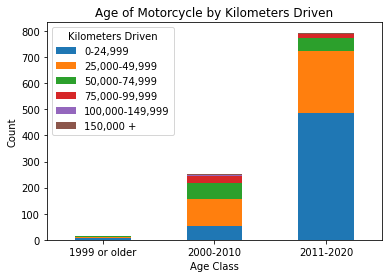

In [33]:
# bar plot of categorical variables above
tabx = pd.crosstab(df.age_class, df.mileage)

tabx.plot.bar(stacked = True)
plt.xticks(rotation = 0)
plt.title("Age of Motorcycle by Kilometers Driven")
plt.xlabel("Age Class")
plt.ylabel("Count")
plt.legend(title = "Kilometers Driven")

The next graph takes a look at the variable `selling_price` of every motorcycle within our data set. We can see a high number of motorcycles below 100,000, along with some outliers at very high price points. 

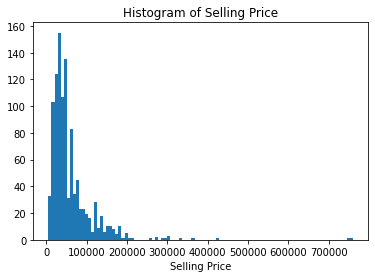

In [59]:
# histogram of selling price
plt.hist(df['selling_price'], bins = 100)
plt.title('Histogram of Selling Price')
plt.xlabel('Selling Price')
plt.show()
plt.close()

The graph below takes a closer look at what we just examined. This is a view of motorcycles with `selling_price` below 100,000 to see a more detailed look. We can see there is more fluctuation of the prices, which wasn't easily visible before. 

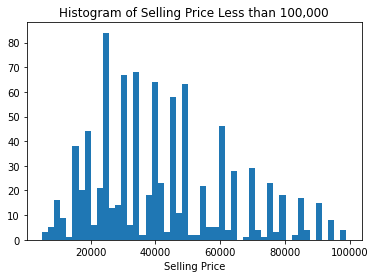

In [76]:
# histogram of selling price less than 100,000 to see the more common prices better
plt.hist(df[df['selling_price'] < 100000]['selling_price'], bins = 50)
plt.title('Histogram of Selling Price Less than 100,000')
plt.xlabel('Selling Price')
plt.show()
plt.close()

Next we'll compare `selling_price` to `km_driven` using a scatter plot. It appears that the relationship between `selling_price` and `km_driven` may be negative and linear. We can use the algorithms in the following sections to find the optimal values of $\beta_0$ and $\beta_1$ that will minimize the difference between actual and predicted values.   

Text(0, 0.5, 'Selling Price')

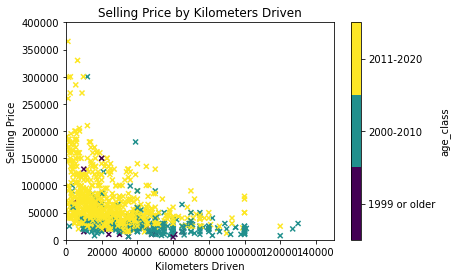

In [30]:
# scatterplot of km driven by selling price
df.plot.scatter(x = "km_driven", y = "selling_price",
                c = "age_class", s = 25, marker = "x", cmap = "viridis", sharex = False)
plt.xlim(0,150000)
plt.ylim(0,400000)
plt.title("Selling Price by Kilometers Driven")
plt.xlabel("Kilometers Driven")
plt.ylabel("Selling Price")

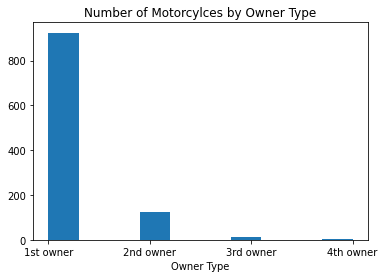

In [97]:
plt.hist(df['owner'])
plt.title('Number of Motorcylces by Owner Type')
plt.xlabel('Owner Type')
plt.show()
plt.close()

In [99]:
# two-way contingency table for owner and year
pd.crosstab(df['year'], df['owner'])

owner,1st owner,2nd owner,3rd owner,4th owner
year,,,,
1988,1,0,0,0
1991,1,0,0,0
1993,0,1,0,0
1995,0,0,1,0
1997,2,0,0,0
1998,2,0,1,0
1999,0,1,0,0
2000,4,0,1,1
2001,1,1,0,0


Finally, we're going to take a look at the variable `km_driven` for all motorcycles in our data set. We can see a large number have driven below 200,000, and somewhere around 150,000 possibly, with some large outliers.

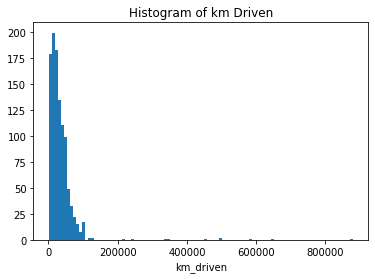

In [92]:
plt.hist(df['km_driven'], bins = 100)
plt.title('Histogram of km Driven')
plt.xlabel('km_driven')
plt.show()
plt.close()

We want to take a closer look at where most of our data lies, so we'll examine the same information but now for motorcycles that have driven less than 150,000 km. There's a bit of a drop off at higher distances, but there are some small increases within that gradual decline.

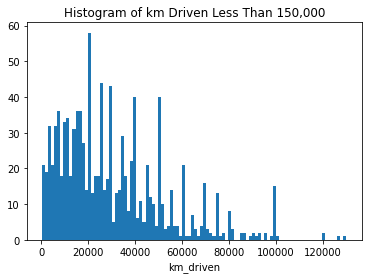

In [93]:
plt.hist(df[df['km_driven'] < 150000]['km_driven'], bins = 100)
plt.title('Histogram of km Driven Less Than 150,000')
plt.xlabel('km_driven')
plt.show()
plt.close()

## Loss Function

If we want to predict a value of **selling_price**, we need to figure out what a good prediction will be. This is typically done using a loss function. One of the common metrics is the root mean square error (RMSE) for our prediction (c) compared to our true values (y), which is the following equation:
$$
RMSE(c) = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-c)^2}
$$
In the different prediction methods, we want to find the prediction that minimizes this value. 

In [7]:
# calculate the RMSE for a list of predicted and actual y values
def rmse(predicted, actual):
    return sqrt(np.square(np.subtract(actual, predicted)).mean())

## Grid Search Algorithm

The first method that we'll use to predict a value of `selling_price` is a grid search algorithm. This will look through manually selected values and determine which is the best predictor for our data. The selected values will be based on the previous exploratory analysis of `selling_price`. We saw a lot of values less than 100,000, and more specifically between a little under 20,000 and 80,000. We'll first examine it just for our y value, using values between 18,000, and 80,250 in increments of 1. We'll also do this for the variable `km_driven`, to see if our algorithm generalizes. The selected values is also based on the previous exploratory analysis, and we'll use values between 0 and 80,000 in increments of 1. After this, we'll examine it for a y and x value. 

### Grid Search Algorithm for just y values

In [90]:
# create a grid of values for c based on previous exploratory analysis
grid = list(range(18000, 80251, 1))

# loop over the grid values and get the rmse for each
rmse_values = []
for c in grid:
    rmse_values.append(rmse(c, df['selling_price']))
    
# get the index of the smallest RMSE from the list 
min_index = rmse_values.index(min(rmse_values))

# get the value from the grid that has the smallest RMSE
print('Optimal value:', grid[min_index])

Optimal value: 59638


In [89]:
# run the algorithm for km_driven to see if this generalizes
# create a grid of values for c based on previous exploratory analysis
grid = list(range(0, 80001, 1))

rmse_values = []
for c in grid:
    rmse_values.append(rmse(c, df['km_driven']))
    
# get the index of the smallest RMSE from the list 
min_index = rmse_values.index(min(rmse_values))

# get the value from the grid that has the smallest RMSE
print('Optimal value:', grid[min_index])

Optimal value: 34360


### Grid Search with *y* and another numeric variable *x*  

Now we'll find the optimal values of $\beta_0$ and $\beta_1$ that connect the variables `selling_price` and `km_driven` in the equation `selling_price` = $\beta_0$ + $\beta_1$*`km_driven`. From the graphs we've created, we deduced that the intercept may be between 0 and 80,000. After iterating over (0, 80000) by 1000, we concluded that we could reduce our grid size to be between 55,000 and 65,000, using a step size of 100. Also based on the graphs, the relationship between `km_driven` and `selling_price` looks mildly negative, so we set the grid values for the slope to be between -1 and 0, using a step size of 0.1.  

In [10]:
#choose grid values
grid_b0 = list(range(55000,65000,100))
grid_b1 = list(np.arange(-1,0,0.1))

#define function
def rmse_slr(b0_grid, b1_grid, x_values, y_values):
    rmsevalz = [100000000] #create list with very large initial value
    dictrmse = dict([]) #create empty dictionary
    
    for x in x_values:
        for b0 in b0_grid:
            for b1 in b1_grid:
                c = b0 + b1*x #define c
                r_mse = rmse(c, y_values) #calculate mse
                if r_mse < min(rmsevalz): #if mse is the minimum mse so far, 
                    rmsevalz.append(r_mse) #add it to the list
                    dictrmse.update(RMSE = [r_mse, b0, b1]) #update the dictionary with new estimates
    return dictrmse #return the optimal estimates


In [11]:
rmse_slr(grid_b0, grid_b1, df.km_driven, df.selling_price)

{'RMSE': [56277.752122003876, 61100, -0.40000000000000013]}

Below we can predict the estimated sale prices for a motorcycle for different values of `km_driven` using our estimates for $\beta_0$ and $\beta_1$ above.  

In [122]:
b0 = 61100
b1 = -0.4

#10,000
print("The estimated sale price for a motorcycle driven 10,000 km is $", b0 + b1*10000)

#25,000
print("The estimated sale price for a motorcycle driven 25,000 km is $", b0 + b1*25000)

#35,000
print("The estimated sale price for a motorcycle driven 35,000 km is $", b0 + b1*35000)

The estimated sale price for a motorcycle driven 10,000 km is $ 57100.0
The estimated sale price for a motorcycle driven 25,000 km is $ 51100.0
The estimated sale price for a motorcycle driven 35,000 km is $ 47100.0


## Gradient Descent Algorithm

The other method we'll look at is the Gradient Descent Algorithm. This is an iterative optimization algorithm that will find the local minimum of a function. This typically uses calculus to find the minimum based on derivatives, but since we don't have a function to derive, we'll estimate this by using a difference quotient. The difference quotient is the following equation:
$$
diff\_quotient = \frac{RMSE(c + \Delta) - RMSE(c)}{\Delta}
$$

This will give us an estimate of the slope of a tangent line. We'll use this slope to calculate our new predicted value and compare the new value to the old value. Once we move a very small distance, we can take a reasonable guess that we're at, or at least close to, the minimum. Our new value will be determined by the equation: $ new\_val = cur\_val + slope * step\_size $, where `step_size` is a set value.  




### Difference Quotient Function

In [9]:
# difference quotient function
def diff_quot(predicted, actual, delta):
    return (rmse(predicted + delta, actual) - rmse(predicted, actual)) / delta

### Gradient Descent for just y

In [13]:
# initialize values for the predicted value, delta, and step size
cur_c = 50000
delta = 0.005
step_size = 0.5

# cap the iterations at 2,000,000 so it doesn't possibly run forever
for _ in range(2000000):
    # calculate the difference quotient for the current predicted value
    diff_quotient = diff_quot(cur_c, df['selling_price'], delta)
    # create a new predicted value based on the difference quotient and step size
    new_c = cur_c - (diff_quotient * step_size)
    # see if the new value is enough of a change to update the predicted value
    if abs(new_c - cur_c) < 0.0001:
        # if this is true, update the value and stop the loop
        cur_c = new_c
        break
    # update the new value and continue with the loop
    cur_c = new_c
    
print('Optimal Value', cur_c)

Optimal Value 59626.89391984968


In [11]:
# initialize values for the predicted value, delta, and step size
cur_c = 50000
delta = 0.005
step_size = 0.5

# cap the iterations at 2,000,000 so it doesn't possibly run forever
for _ in range(2000000):
    # calculate the difference quotient for the current predicted value
    diff_quotient = diff_quot(cur_c, df['km_driven'], delta)
    # create a new predicted value based on the difference quotient and step size
    new_c = cur_c - (diff_quotient * step_size)
    # see if the new value is enough of a change to update the predicted value
    if abs(new_c - cur_c) < 0.0001:
        # if this is true, update the value and stop the loop
        cur_c = new_c
        break
    # update the new value and continue with the loop
    cur_c = new_c
    
print('Optimal Value', cur_c)

Optimal Value 34370.15023825297


### Gradient Descent with *y* and another numeric variable *x*  

Now we'll use the gradient descent method using `km_driven` as an *x* variable for `selling_price` *y*. First we'll create the necessary functions, then run the algorithm to produce estimates for $\beta_0$ and $\beta_1$.  

In [118]:
# create squared error loss function  
def squerrls(y, x, b_0, b_1):
    return (y - b_0 - b_1*x)**2

# rmse func
def rmse_mult(y, x, b_0, b_1):
    return sqrt(squerrls(y, x, b_0, b_1).mean())

# difference quotient for b0
def diffquot_b0(y, x, b_0, delta_0, b_1):
    numerator = rmse_mult(y, x, b_0 + delta_0, b_1) - rmse_mult(y, x, b_0, b_1)
    return numerator/delta_0

# difference quotient for b1
def diffquot_b1(y, x, b_0, b_1, delta_1):
    numerator = rmse_mult(y, x, b_0, b_1 + delta_1) - rmse_mult(y, x, b_0, b_1)
    return numerator/delta_1


The starting values for `cur_b0` and `cur_b1` are based on the resulting values for these parameters from the grid search algorithm. We've chosen `delta` to a very small number so we can get an accurate slope estimate for the tangent line for each iteration. The step size for $\beta_0$ is larger than the step size for $\beta_1$ because we expect the intercept to have a much larger value than the slope, so these step sizes will increase precision.  

In [119]:
#set parameter values
cur_b0 = 61100
cur_b1 = -0.4
delta = 0.005
step_size_b0 = 1
step_size_b1 = 0.000005
y = df.selling_price
x = df.km_driven

#begin iteration but limit number of iterations to 2000000
for _ in range(2000000):
    #compute diff quotient b0
    diff_quotient_b0 = diffquot_b0(y, x, cur_b0, delta, cur_b1)
    #compute new b0 value
    new_b0 = cur_b0 - diff_quotient_b0*step_size_b0
    #compute diff quotient b1
    diff_quotient_b1 = diffquot_b1(y, x, new_b0, cur_b1, delta)
    #compute new b1 value
    new_b1 = cur_b1 - diff_quotient_b1*step_size_b1
    #create old vector and new vector
    point1 = np.array((cur_b0, cur_b1))
    point2 = np.array((new_b0, new_b1))
    #if the absolute difference between vectors is less than this value, replace old vector with new vector
    #and break
    if abs(np.linalg.norm(point1 - point2)) < 0.0001:
        cur_b0 = new_b0
        cur_b1 = new_b1
        break
    #replace old values with new values
    cur_b0 = new_b0
    cur_b1 = new_b1
    
print("The optimal value for b_0 is: ", cur_b0, "and the optimal value for b_1 is: ", cur_b1)

The optimal value for b_0 is:  67734.12116574764 and the optimal value for b_1 is:  -0.23578317893947628


Finally, we can once again predict `selling_price` from `km_driven` using our new estimates for $\beta_0$ and $\beta_1$.  

In [121]:
b0 = cur_b0
b1 = cur_b1

#10,000
print("The estimated sale price for a motorcycle driven 10,000 km is $", cur_b0 + cur_b1*10000)

#25,000
print("The estimated sale price for a motorcycle driven 25,000 km is $", cur_b0 + cur_b1*25000)

#35,000
print("The estimated sale price for a motorcycle driven 35,000 km is $", cur_b0 + cur_b1*35000)

The estimated sale price for a motorcycle driven 10,000 km is $ 65376.28937635288
The estimated sale price for a motorcycle driven 25,000 km is $ 61839.54169226073
The estimated sale price for a motorcycle driven 35,000 km is $ 59481.70990286597
